# Project description

Aim of the project is to determine the age of the subject form his portrait picture.

The MAE metric on the test set should not be more than 8.

Data description:
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with two labels columns: `file_name` and `real_age`

## Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

In [2]:
%%time
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.
CPU times: user 665 ms, sys: 485 ms, total: 1.15 s
Wall time: 1min 23s


## EDA

In [12]:
print(('Batches:\t' + str(len(train_gen_flow)) ).expandtabs(20))
print(('x_col, y_col:\t' + str(len(train_gen_flow[0])) ).expandtabs(20))
print(('Batch photos:\t' + str(len(train_gen_flow[0][0])) ).expandtabs(20))
print(('x pixel count:\t' + str(len(train_gen_flow[0][0][0])) ).expandtabs(20))
print(('y pixel count:\t' + str(len(train_gen_flow[0][0][0][0])) ).expandtabs(20))
print(('RGB channels:\t' + str(len(train_gen_flow[0][0][0][0][0])) ).expandtabs(20))

Batches:            238
x_col, y_col:       2
Batch photos:       32
x pixel count:      224
y pixel count:      224
RGB channels:       3


### Findings

In [10]:
%%time

age = []
for i in range(len(train_gen_flow)):
    age.append(train_gen_flow[i][1])

age_df = pd.DataFrame(age)

CPU times: user 35.9 s, sys: 2.4 s, total: 38.3 s
Wall time: 7min 39s


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
dtype: float64


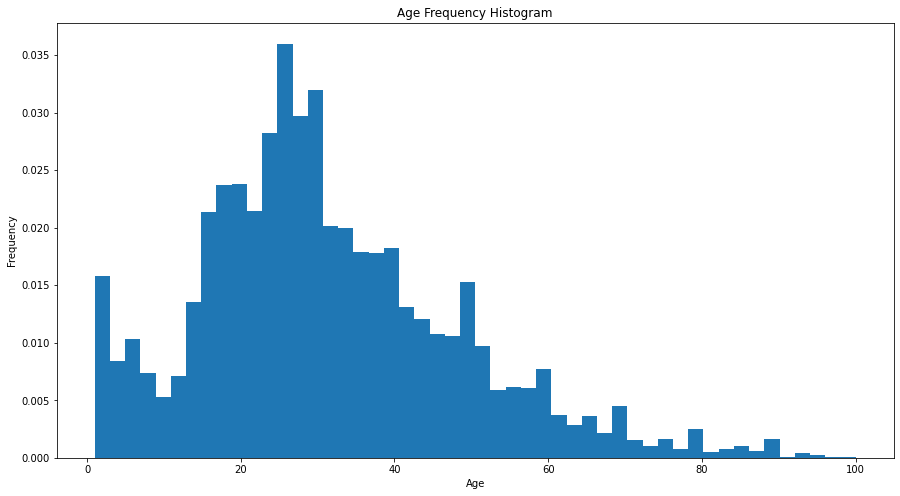

In [11]:
print(age_df.unstack().dropna().describe())

x = age_df.unstack().dropna().values
plt.gcf().set_size_inches(15, 8)
plt.hist(x, bins=50,density=True)
plt.gca().set(title='Age Frequency Histogram', 
              ylabel='Frequency',
              xlabel='Age');

* Most of the photos are of people ages 20-41.
* Long tail distribution for ages +60.
* Increase in number of photos for ages <10.
* The dataset age distribution mimic real life age pyramid making it good for out model.


### Print 10-15 photos for different ages:

In [12]:
def print_pic(datagen,age):
    flag = False  
    
    for i in range(len(datagen)):
        for j in range(len(datagen[i][0])):
            if datagen[i][1][j] == age:
                plt.figure()
                plt.imshow(datagen[i][0][j])
                plt.title('Age: '+str(age));
                
                flag = True
                break

        if flag == True:
            break

CPU times: user 12min 31s, sys: 29.6 s, total: 13min
Wall time: 21min 11s


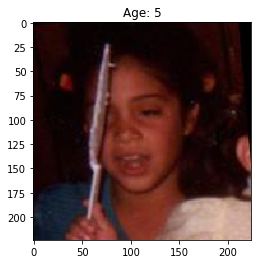

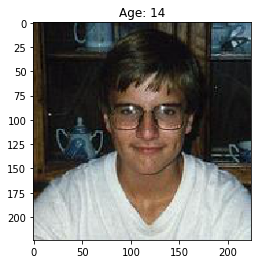

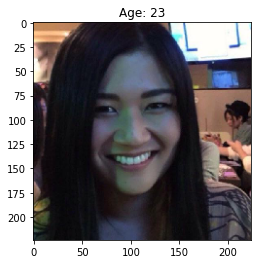

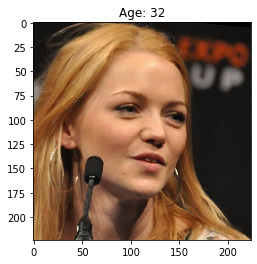

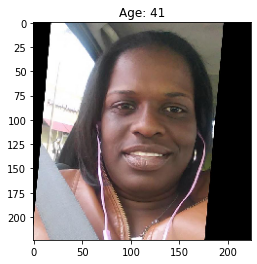

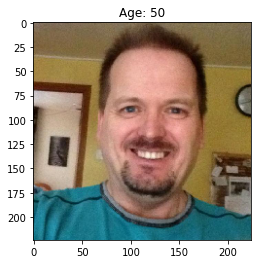

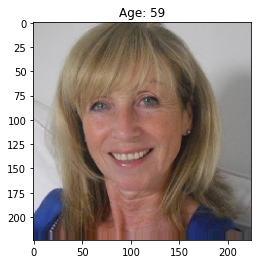

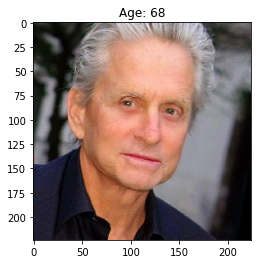

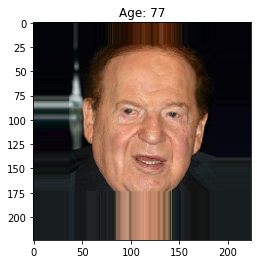

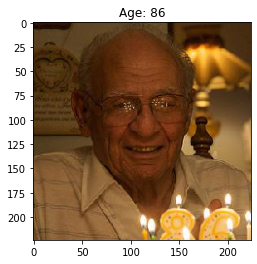

In [13]:
%%time
for i in range(5,90,9):
    print_pic(train_gen_flow,i)

## Modelling

In [14]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [15]:
def load_train(path):

    train_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1/255,
            featurewise_center = True,
            samplewise_std_normalization= True,
            horizontal_flip=True,
            rotation_range = 20,
            width_shift_range=0.2,
            brightness_range=(0.7, 1),
            zoom_range=[0.8, 1.2],
            channel_shift_range=42,
            fill_mode='nearest'
        )
    
    labels = pd.read_csv('/datasets/faces/labels.csv')

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
        
    return train_gen_flow

In [16]:
def load_test(path):
    
    train_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1/255,
        )
    
    labels = pd.read_csv('/datasets/faces/labels.csv')

    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
   
    return test_gen_flow

In [17]:
def create_model(input_shape =(224, 224, 3)):
    
    optimizer = Adam(learning_rate=0.0001)
    # 'imagenet' classes=100
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False, )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='relu')) 

    model.compile(
        optimizer= optimizer,
        loss='mean_squared_error',
        metrics=['mean_absolute_error'])
    
    return model

In [18]:
model = create_model()
model.summary()

2022-07-07 15:32:04.662639: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [19]:
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=25,
                steps_per_epoch=None, 
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

### Output

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps

Epoch 1/25
178/178 - 114s - loss: 321.4480 - mean_absolute_error: 13.0077 - val_loss: 451.6305 - val_mean_absolute_error: 16.1716
Epoch 2/25
178/178 - 106s - loss: 110.8541 - mean_absolute_error: 7.9241 - val_loss: 603.3669 - val_mean_absolute_error: 19.5587
Epoch 3/25
178/178 - 106s - loss: 89.1622 - mean_absolute_error: 7.1645 - val_loss: 395.2462 - val_mean_absolute_error: 14.8739
Epoch 4/25
178/178 - 106s - loss: 78.9544 - mean_absolute_error: 6.7331 - val_loss: 219.6892 - val_mean_absolute_error: 11.2207
Epoch 5/25
178/178 - 106s - loss: 71.8790 - mean_absolute_error: 6.4686 - val_loss: 104.3125 - val_mean_absolute_error: 7.7108
Epoch 6/25
178/178 - 106s - loss: 63.0868 - mean_absolute_error: 6.0457 - val_loss: 116.6498 - val_mean_absolute_error: 7.8644
Epoch 7/25
178/178 - 105s - loss: 55.7864 - mean_absolute_error: 5.7408 - val_loss: 103.7190 - val_mean_absolute_error: 7.6422
Epoch 8/25
178/178 - 106s - loss: 53.5684 - mean_absolute_error: 5.5489 - val_loss: 108.2585 - val_mean_absolute_error: 7.8006
Epoch 9/25
178/178 - 106s - loss: 47.6393 - mean_absolute_error: 5.3177 - val_loss: 212.9845 - val_mean_absolute_error: 11.7960
Epoch 10/25
178/178 - 106s - loss: 44.9876 - mean_absolute_error: 5.1523 - val_loss: 115.5076 - val_mean_absolute_error: 7.9504
Epoch 11/25
178/178 - 105s - loss: 44.3102 - mean_absolute_error: 5.1387 - val_loss: 105.8062 - val_mean_absolute_error: 7.7681
Epoch 12/25
178/178 - 106s - loss: 40.0854 - mean_absolute_error: 4.8590 - val_loss: 97.6835 - val_mean_absolute_error: 7.2770
Epoch 13/25
178/178 - 105s - loss: 38.0840 - mean_absolute_error: 4.7008 - val_loss: 85.7834 - val_mean_absolute_error: 6.8185
Epoch 14/25
178/178 - 106s - loss: 35.0931 - mean_absolute_error: 4.5708 - val_loss: 155.3499 - val_mean_absolute_error: 9.3183
Epoch 15/25
178/178 - 106s - loss: 34.6542 - mean_absolute_error: 4.5441 - val_loss: 115.7868 - val_mean_absolute_error: 8.2153
Epoch 16/25
178/178 - 105s - loss: 32.1097 - mean_absolute_error: 4.3574 - val_loss: 132.4095 - val_mean_absolute_error: 8.6648
Epoch 17/25
178/178 - 106s - loss: 30.5274 - mean_absolute_error: 4.2618 - val_loss: 113.7462 - val_mean_absolute_error: 7.8816
Epoch 18/25
178/178 - 106s - loss: 29.8872 - mean_absolute_error: 4.1721 - val_loss: 90.1038 - val_mean_absolute_error: 7.0384
Epoch 19/25
178/178 - 106s - loss: 27.6629 - mean_absolute_error: 4.0384 - val_loss: 175.7983 - val_mean_absolute_error: 9.8947
Epoch 20/25
178/178 - 107s - loss: 26.6008 - mean_absolute_error: 3.9288 - val_loss: 107.7923 - val_mean_absolute_error: 7.6074
Epoch 21/25
178/178 - 106s - loss: 25.6341 - mean_absolute_error: 3.8585 - val_loss: 129.1207 - val_mean_absolute_error: 8.3470
Epoch 22/25
178/178 - 106s - loss: 24.5620 - mean_absolute_error: 3.7696 - val_loss: 85.6708 - val_mean_absolute_error: 6.8654
Epoch 23/25
178/178 - 105s - loss: 22.9993 - mean_absolute_error: 3.6853 - val_loss: 83.8921 - val_mean_absolute_error: 6.7774
Epoch 24/25
178/178 - 106s - loss: 21.9208 - mean_absolute_error: 3.5887 - val_loss: 90.2726 - val_mean_absolute_error: 7.0170
Epoch 25/25
178/178 - 106s - loss: 22.5266 - mean_absolute_error: 3.6471 - val_loss: 93.9210 - val_mean_absolute_error: 7.1773

60/60 - 10s - loss: 93.9210 - mean_absolute_error: 7.1773
Test MAE: 7.1773

## Conclusions

* Although the model is overfited it still does a good job at predicting age from photos it never seen before.
* Test MAE: 7.1773